In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import gaussian_kde, multivariate_normal
from matplotlib import pyplot as plt
# data preprocessing

### Data Preprocessing Function
Preprocessing done externally.

### Objective function
In optimization, particularly in PSO, the goal is often to minimize the objective function. The objective function consists of two components:

1) __Kernel Density Estimator__ - This is a probability density function based on the positions of all defensive players. The algorithim is "rewarded" for being in areas of higher density. In other words, __swarming__ as a defensive unit.

2) __Gaussian__ - A distribution of space around the ball carrier. The algorithim is "rewarded" by being in areas of higher tackle probability.

These are combined to reward the entire defensive unit swarming the ball carrier.

In [2]:
# objective functions
def kde_obj(
    positions,
    kde_interpolator,
    gaussian_interpolator,
    gaussian_weight=0.4
) -> float:

    positions = np.atleast_2d(positions)
    print('Positions: ', positions)
    kde_values = kde_interpolator(positions)
    gaussian_values = gaussian_interpolator(positions)
    objective_values = kde_values + -1*gaussian_weight * gaussian_values

    return -objective_values

In [3]:
class PSODefense:
    def __init__(self, frame: pd.DataFrame, objective_function):

        self.objective_function = objective_function
        self.frame = frame
        self.xmin = 0
        self.xmax = 120  # Including endzones
        self.ymax = 53.3  # Standard width of a football field
        self.ymin = 0
        self.min_velocity = -0.5
        self.max_velocity = 0.5

        defense = frame.loc[frame['club'] == 'SF']
        offense = frame.loc[frame['club'] == 'CHI']

        self.num_particles = len(defense)
        self.num_dimensions = 2
        self.num_obstacles = len(offense)

        self.positions = defense[['x', 'y']].values
        self.velocities = defense[['x_velocity', 'y_velocity']].values
        self.obs_positions = offense[['x', 'y']].values
        self.obs_velocities = offense[['x_velocity', 'y_velocity']].values

        self.personal_best_positions = self.positions.copy()
        self.personal_best_scores = np.full(len(defense), np.inf)

        self.global_best_score = np.inf
        self.global_best_position = None

        # initialize the objective function parameters
        self.objective_function_params = self.init_objective_function_params()

        # hyper parameters
        self.w = 1
        self.c1 = 2
        self.c2 = 2
        self.num_iterations = 1

    def init_objective_function_params(self):
        offense = self.frame.loc[(self.frame['club'] == 'CHI') & (
            self.frame['nflId'] != 53646)]
        x, y = offense['x'].values, offense['y'].values
        data = np.vstack((x, y))

        gaussian_kernel = gaussian_kde(data)
        xx, yy = np.mgrid[self.xmin:self.xmax:100j, self.ymin:self.ymax:100j]

        positions = np.vstack([xx.ravel(), yy.ravel()])
        f = np.reshape(gaussian_kernel(positions).T, xx.shape)
        kde_interpolator = RegularGridInterpolator((xx[:, 0], yy[0, :]), f)

        ball_carrier = self.frame.loc[(self.frame['club'] == 'CHI') & (
            self.frame['nflId'] == 53646)]
        ball_carrier_mean = ball_carrier[['x', 'y']].values[0]
        ball_carrier_std_dev = 1
        ball_carrier_covariance = np.diag(
            [ball_carrier_std_dev**2, ball_carrier_std_dev**2])

        pos = np.dstack((xx, yy))
        rv = multivariate_normal(ball_carrier_mean, ball_carrier_covariance)
        f = rv.pdf(pos)
        gaussian_interpolator = RegularGridInterpolator(
            (xx[:, 0], yy[0, :]), f)

        return {
            'kde_interpolator': kde_interpolator,
            'gaussian_interpolator': gaussian_interpolator,
            'gaussian_weight': 0.5
        }

    def calculate_repulsion_forces(self, obstacle_influence_radius):
        repulsion_forces = np.zeros((self.num_particles, self.num_dimensions))
        for i in range(self.num_particles):
            for j in range(self.num_obstacles):
                distance = np.linalg.norm(
                    self.positions[i] - self.obs_positions[j])
                if distance < obstacle_influence_radius:
                    repulsion_vector = self.positions[i] - self.obs_positions[j]
                    repulsion_force = repulsion_vector / (distance**2)
                    repulsion_forces[i] += repulsion_force
        return repulsion_forces

    def optimize(self, obstacle_influence_radius=500):
        for _ in range(self.num_iterations):
            fitness = self.objective_function(self.positions, **self.objective_function_params)
            repulsion_forces = self.calculate_repulsion_forces(obstacle_influence_radius)

            for i in range(self.num_particles):
                if fitness[i] < self.personal_best_scores[i]:
                    self.personal_best_scores[i] = fitness[i]
                    self.personal_best_positions[i] = self.positions[i]

                if fitness[i] < self.global_best_score:
                    self.global_best_score = fitness[i]
                    self.global_best_position = self.positions[i]

                # Update the velocities with the new repulsion force component
                self.velocities[i] = (
                    self.w * self.velocities[i]
                    + self.c1 * np.random.rand() * (self.personal_best_positions[i] - self.positions[i])
                    + self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                    + repulsion_forces[i]  # Obstacle avoidance component
                )

                self.velocities[i] = np.clip(self.velocities[i], self.min_velocity, self.max_velocity)
                self.positions[i] += self.velocities[i]
                self.positions[i] = np.clip(self.positions[i], [self.xmin, self.ymin], [self.xmax, self.ymax])

        return self.global_best_score, self.global_best_position

Positions:  [[ 86.12  29.12]
 [103.29  35.3 ]
 [102.02  31.25]
 [102.31  27.42]
 [100.45  30.47]
 [ 99.28  21.23]
 [ 99.99  39.09]
 [101.07  28.24]
 [104.51  32.64]
 [101.13  29.28]
 [100.27  25.94]]


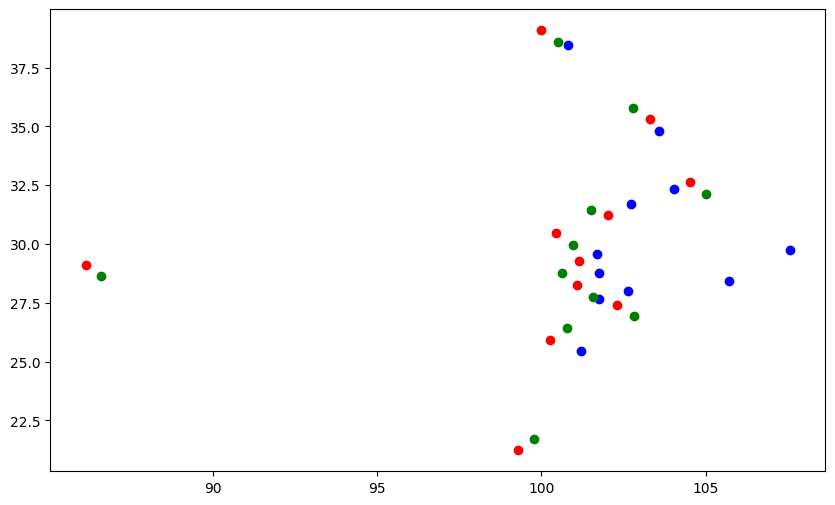

In [4]:
df = pd.read_csv('../../data/example_play.csv')
frame = df.loc[df['frameId'] == 20]
pso = PSODefense(
    frame=frame,
    objective_function=kde_obj
)
# optimize
global_best_score, global_best_position = pso.optimize()
new_velocities = pso.velocities
new_positions = pso.positions

fig, ax = plt.subplots(figsize=(10, 6))

offense = frame.loc[frame['club'] == 'CHI']
defense = frame.loc[frame['club'] == 'SF']

ax.scatter(offense['x'], offense['y'], c='blue', label='Offense')
ax.scatter(defense['x'], defense['y'], c='red', label='Defense')
ax.scatter(
    global_best_position[0], global_best_position[1], c='yellow', label='Global Best')
# plot new positions
ax.scatter(new_positions[:, 0], new_positions[:, 1],
            c='green', label='New Positions')
plt.show()